<a href="https://colab.research.google.com/github/RyanBalshaw/Nonlinear_ICA_implementations/blob/main/Nonlinear_ICA_using_TCL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import linear_sum_assignment

In [ ]:
def apply_MLP_to_source(source,
                        num_layer,
                        num_segment = None,
                        iter4condthresh = 10000,
                        cond_thresh_ratio = 0.25,
                        layer_name_base = 'ip',
                        save_layer_data = False,
                        Arange=None,
                        nonlinear_type = 'ReLU',
                        negative_slope = 0.2,
                        random_seed=0):
    """Generate MLP and Apply it to source signal.
    Args:
        source: source signals. 2D ndarray [num_comp, num_data]
        num_layer: number of layers
        num_segment: (option) number of segments (only used to modulate random_seed)
        iter4condthresh: (option) number of random iteration to decide the threshold of condition number of mixing matrices
        cond_thresh_ratio: (option) percentile of condition number to decide its threshold
        layer_name_base: (option) layer name
        save_layer_data: (option) if true, save activities of all layers
        Arange: (option) range of value of mixing matrices
        nonlinear_type: (option) type of nonlinearity
        negative_slope: (option) parameter of leaky-ReLU
        random_seed: (option) random seed
    Returns:
        mixedsig: sensor signals. 2D ndarray [num_comp, num_data]
        mixlayer: parameters of mixing layers
    """
    if Arange is None:
        Arange = [-1, 1]
    print("Generating sensor signal...")

    # Subfuction to normalize mixing matrix
    def l2normalize(Amat, axis=0):
        # axis: 0=column-normalization, 1=row-normalization
        l2norm = np.sqrt(np.sum(Amat*Amat,axis))
        Amat = Amat / l2norm
        return Amat

    # Initialize random generator
    np.random.seed(random_seed)
    # To change random_seed based on num_layer and num_segment
    for i in range(num_layer):
        np.random.rand()
    if num_segment is not None:
        for i in range(num_segment):
            np.random.rand()

    num_comp = source.shape[0]

    # Determine condThresh ------------------------------------
    condList = np.zeros([iter4condthresh])
    for i in range(iter4condthresh):
        A = np.random.uniform(Arange[0],Arange[1],[num_comp,num_comp])
        A = l2normalize(A, axis=0)
        condList[i] = np.linalg.cond(A)

    condList.sort() # Ascending order
    condThresh = condList[int(iter4condthresh * cond_thresh_ratio)]
    print("    cond thresh: {0:f}".format(condThresh))

    # Generate mixed signal -----------------------------------
    mixedsig = source.copy()
    mixlayer = []
    for ln in range(num_layer-1,-1,-1):

        # Apply nonlinearity ----------------------------------
        if ln < num_layer-1: # No nolinearity for the first layer (source signal)
            if nonlinear_type == "ReLU": # Leaky-ReLU
                mixedsig[mixedsig<0] = negative_slope * mixedsig[mixedsig<0]
            else:
                raise ValueError

        # Generate mixing matrix ------------------------------
        condA = condThresh + 1
        while condA > condThresh:
            A = np.random.uniform(Arange[0], Arange[1], [num_comp, num_comp])
            A = l2normalize(A)  # Normalize (column)
            condA = np.linalg.cond(A)
            print("    L{0:d}: cond={1:f}".format(ln, condA))
            
        # Bias
        b = np.zeros([num_comp]).reshape([1,-1]).T

        # Apply bias and mixing matrix ------------------------
        mixedsig = mixedsig + b
        mixedsig = np.dot(A, mixedsig)

        # Storege ---------------------------------------------
        layername = layer_name_base + str(ln+1)
        mixlayer.append({"name":layername, "A":A.copy(), "b":b.copy()})
        # Storege data
        if save_layer_data:
            mixlayer[-1]["x"] = mixedsig.copy()

    return mixedsig, mixlayer

In [ ]:
class mixing_MLP(nn.Module):#Unused, found version from TCL
    def __init__(self, n_size, n_layers):
        super(mixing_MLP, self).__init__()
        
        self.layers = []
        self.activation = nn.LeakyReLU(negative_slope = 0.1)
        
        for i in range(n_layers):
            self.layers.append(nn.Linear(n_size, n_size))
            self.layers.append(self.activation)
        
        self.layers.pop(-1)
        
        self.model = nn.Sequential(*self.layers)
        #self.model.apply(self.init_weights)
    
    @staticmethod
    def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
    
    def forward(self, x):
        with torch.no_grad():
            return self.model(x)

class Maxout_linear_layer(nn.Module):
    def __init__(self, in_features, out_features, k, bias = True):
        super(Maxout_linear_layer, self).__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.k = k
        self.bias = bias
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        self.maxout_layer = nn.Linear(self.in_features, k * self.out_features, bias = self.bias)
        self.maxout_layer.apply(self.init_weights)

    @staticmethod
    def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            #m.bias.data.fill_(0.01) 
        
    def forward(self, x):
        
        maxout = self.maxout_layer(x)

        maxout = maxout.reshape(-1, self.out_features, self.k)
        
        maxout, indices = torch.max(maxout, 2)

        return maxout

class feature_MLP(nn.Module):#exactly the same as the mixing MLP
    def __init__(self, n_size, n_layers, maxout_flag = False):
        super(feature_MLP, self).__init__()
        
        self.layers = []
        self.activation = nn.LeakyReLU(negative_slope = 0.1)#nn.LeakyReLU(negative_slope = 0.05) #nn.ReLU()#
        
        for i in range(n_layers):
            if maxout_flag:
                self.layers.append(Maxout_linear_layer(n_size, n_size, 2))
            
            else:
                """
                if i == 0:
                    self.layers.append(nn.Linear(n_size, 64))
                
                elif i == n_layers - 1:
                    self.layers.append(nn.Linear(64, n_size))
                
                else:
                    self.layers.append(nn.Linear(64, 64))
                """
                self.layers.append(nn.Linear(n_size, n_size))
                self.layers.append(self.activation)
        
        if maxout_flag:
            self.layers.pop(0) #remove the first one, as we only care about Lfeature = Lmixture
            self.layers.append(nn.Linear(n_size, n_size)) #Append a final linear layer
        
        else:
            self.layers.pop(-1)

        self.model = nn.Sequential(*self.layers)
        self.model.apply(self.init_weights)
    
    @staticmethod
    def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            #m.bias.data.fill_(0.01)
  
    def forward(self, x):
        return self.model(x)
    
class RegressionModel(nn.Module):
    def __init__(self, n_size):
        super(RegressionModel, self).__init__()
        
        #define tensors that we can optimise
        self.a1 = nn.parameter.Parameter(torch.ones(1, n_size), requires_grad = True)
        self.a2 =nn.parameter.Parameter(torch.ones(1, n_size), requires_grad = True)
        self.b = nn.parameter.Parameter(torch.ones(1, n_size), requires_grad = True) 
        
        #define tensors that we can optimise
        self.a_tilde = nn.parameter.Parameter(torch.ones(1, n_size), requires_grad = True)
        self.b_tilde = nn.parameter.Parameter(torch.ones(1, n_size), requires_grad = True) #A tensor that we can optimise
        self.c = nn.parameter.Parameter(torch.ones(1, 1), requires_grad = True) #A scalar that we can optimise
        
        self.activation = nn.Sigmoid()
        
        #initialise parameters
        self.init_params()
    
    def init_params(self):
        for i in self.parameters():
            torch.nn.init.xavier_uniform_(i)
        
    def forward(self, h1, h2):
        #First half of regression
        p1_1 = self.a1 * h1 #element-wise product through the rows of h1
        p1_2 = self.a2 * h2 #element-wise product through the rows of h1
        
        #second half
        p2_1 = self.a_tilde * h1
        
        #combine
        p1 = torch.abs(p1_1 + p1_2 + self.b)
        p2 = -1 * (p2_1 + self.b_tilde)**2
        
        p_total = self.activation(-1 * torch.sum(p1 + p2 + self.c, dim = 1))
        
        return p_total

class RegressionModel2(nn.Module):
    def __init__(self, n_size, n_layers = 1): #Takes in H1, H2 and returns a prediction
        super(RegressionModel2, self).__init__()

        self.layers = []
        self.activation = nn.Sigmoid()

        for i in range(n_layers):
          self.layers.append(nn.Linear(n_size * 2, n_size * 2))
          self.layers.append(nn.ReLU())

        self.layers.append(nn.Linear(n_size * 2, 1))

        self.model = nn.Sequential(*self.layers)
        self.model.apply(self.init_weights)
    
    @staticmethod
    def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
    
    def forward(self, h1, h2):

      h_total = torch.hstack((h1, h2))
      out = self.activation(self.model(h_total))

      return out.reshape(-1)
        
def TCL_sampler(no_samples, n = 2, phi = 0.05, rho = 0.7, c = 0):

    z_t0 = np.random.normal(0, 0.1, n)

    sim_sample = np.zeros((no_samples, n))
    sim_sample[0] = z_t0

    for i in range(1, no_samples, 1):
        lap_sample = []
        for j in range(n):
            lap_sample.append(np.random.laplace(loc = rho * sim_sample[i - 1, j], scale = 1, size = 1)[0])
        
        lap_sample = np.array(lap_sample)#0.1 * np.random.randn(n_size)#

        sim_sample[i, :] = c + phi * sim_sample[i - 1, :] + lap_sample
    
    if n == 2:
        angles = np.arctan2(sim_sample[:, 1], sim_sample[:, 0]) + np.pi
        arg_index = np.argsort(angles)
        undo_arg_index = np.argsort(arg_index)

        color = plt.cm.jet(np.linspace(0, 1, no_samples))[undo_arg_index]#

        return sim_sample, color
    
    else:
        return sim_sample

class TCL_dataset_maker(object):
    #The objective here is to take the samples, push them through a mixing MLP 
    #and then return the Y tuple for real and fake data
    
    def __init__(self, no_samples, L, n = 2, phi = 0.6, rho = 0.7, c = 0):
        self.no_samples = no_samples
        self.n = n
        self.phi = phi
        self.rho = rho
        self.c = c
        self.L = L
        self.batch_cnt = 0
        
        if self.n == 2:
            self.samples, self.colors = TCL_sampler(self.no_samples, self.n, self.phi, self.rho, self.c)
            
        else:
            self.samples = TCL_sampler(self.no_samples, self.n, self.phi, self.rho, self.c)
        
        #Convert samples to torch tensor
        self.samples = torch.from_numpy(self.samples.astype('float32'))
        
        #Normalise
        self.mean = torch.mean(self.samples, dim = 0)
        self.std = torch.std(self.samples, dim = 0)
        
        #self.samples = (self.samples - self.mean) / self.std
        
        #Mixing
        #elf.mixing_mlp = mixing_MLP(self.n, self.L)   
        #print(self.mixing_mlp)
        #self.mixed_samples = self.mixing_mlp(self.samples)
        mixed_data, mix_layer = apply_MLP_to_source(self.samples.cpu().numpy().T, self.L)
        mixed_data = torch.from_numpy(mixed_data.T).float()
        self.mixed_samples = mixed_data
    
        #Make datasets
        self.Yreal = self.make_real()
        self.Yfake, self.Yfake_indices = self.make_fake()

        #Make test/train datasets
        self.Yreal_train, self.Yreal_test, self.Yfake_train, self.Yfake_test = self.train_test_split()
    
    def make_real(self):
        list_samples = []
        
        for i in range(self.no_samples - 1):
            list_samples.append((self.mixed_samples[i + 1, :], self.mixed_samples[i, :], 1))
        
        return list_samples
    
    def make_fake(self):#Question, do the fake samples generate all the time or is it dynamic?
        #assuming static fake (maybe why they perform L2 regularisation)
        #Takes in the samples, returns the Yreal tuple of the form (Y1, Y2_fake, 0)
        list_samples = []
        fake_index = np.random.randint(0, self.no_samples, self.no_samples)
        
        for cnt, i in enumerate(fake_index, start = 1):
            if i == cnt or abs(i - cnt) < 100:
                #print(i, cnt + 1)
                while fake_index[cnt] == cnt or abs(fake_index[cnt] - cnt) < 100:#while loop to ensure that you replace it with something else
                    fake_index[cnt] = np.random.randint(0, self.no_samples, 1) #replace
        
        for i in range(self.no_samples - 1):
            
            list_samples.append((self.mixed_samples[i + 1, :], self.mixed_samples[fake_index[i], :], 0))
      
        return list_samples, fake_index
    
    def train_test_split(self): #80-20 split
        N = len(self.Yreal) #Same length for Yfake

        rand_indices = list(range(N))
        np.random.seed(0)
        np.random.shuffle(rand_indices)

        self.no_train_samples = int(0.8 * N)
        
        self.rand_indices = rand_indices

        Yr_train = [ self.Yreal[i] for i in self.rand_indices[:self.no_train_samples] ]
        Yr_test = [ self.Yreal[i] for i in self.rand_indices[self.no_train_samples:] ]

        Yf_train = [ self.Yfake[i] for i in self.rand_indices[:self.no_train_samples] ]
        Yf_test = [ self.Yfake[i] for i in self.rand_indices[self.no_train_samples:] ]

        return Yr_train, Yr_test, Yf_train, Yf_test

    def batch_sample(self, batch_size, train_batch = True, include_end = False):

        actual_batch_size = int(batch_size / 2)

        if train_batch:
            Dreal = self.Yreal_train
            Dfake = self.Yfake_train
            
        else: #use the test data
            Dreal = self.Yreal_test
            Dfake = self.Yfake_test
        
        N = len(Dreal)

        if self.batch_cnt > (N - 1) // actual_batch_size: #check that you are not further than you can go
            self.batch_cnt = 0 #reset counter

            return None, None, None, False

        elif self.batch_cnt == (N - 1) // actual_batch_size and not include_end: #end check no. 1 (for not including end)
            self.batch_cnt = 0 #reset counter

            return None, None, None, False
        
        elif self.batch_cnt == (N - 1) // actual_batch_size and include_end: #end check no. 2 (for including end) - set the flag to true and then run with it
          flag = True
          start = self.batch_cnt * actual_batch_size
          end = min((self.batch_cnt + 1) * actual_batch_size, N)

        else:
            flag = True
            start = self.batch_cnt * actual_batch_size
            end = min((self.batch_cnt + 1) * actual_batch_size, N)
        
        sample_indices = np.arange(start, end, 1)

        Y1 = torch.zeros(2 * int(end - start), self.n) #Double because start:end is half the batch size
        Y2 = torch.zeros(2 * int(end - start), self.n)
        labels = torch.zeros(2 * int(end - start))

        cnt = 0
        
        for i in sample_indices:
            Y1[cnt, :] = Dreal[i][0]
            Y2[cnt, :] = Dreal[i][1]
            labels[cnt] = Dreal[i][2]
            cnt += 1
        
        for i in sample_indices: #Same indices are used from the fake case
            Y1[cnt, :] = Dfake[i][0]
            Y2[cnt, :] = Dfake[i][1]
            labels[cnt] = Dfake[i][2]
            cnt += 1
        
        self.batch_cnt += 1
        
        return Y1, Y2, labels, flag

    def random_sample(self, batch_size, train_batch = True):
        #Assuming equal batch sizes
        #Need to return the Y1, Y1 and the labels
        #1 big thing, so both real and fake at the same time
        #Basically just randomly sample the indices, stack the x(t)s and x(t-1)s and the indices, return as a tuple
        if train_batch:
            Dreal = self.Yreal_train
            Dfake = self.Yfake_train
            
        else: #use the test data
            Dreal = self.Yreal_test
            Dfake = self.Yfake_test

        rand_sample_real = np.random.randint(0, self.no_train_samples, batch_size // 2)
        rand_sample_fake = np.random.randint(0, self.no_train_samples, int(batch_size - batch_size // 2))
        
        #Not the best, but a good start
        #Loop through the indices and extract everything
        
        Y1 = torch.zeros(batch_size, self.n)
        Y2 = torch.zeros(batch_size, self.n)
        labels = torch.zeros(batch_size)
        cnt = 0
        
        for i in rand_sample_real:
            Y1[cnt, :] = Dreal[i][0]
            Y2[cnt, :] = Dreal[i][1]
            labels[cnt] = Dreal[i][2]
            cnt += 1
        
        for i in rand_sample_fake:
            Y1[cnt, :] = Dfake[i][0]
            Y2[cnt, :] = Dfake[i][1]
            labels[cnt] = Dfake[i][2]
            cnt += 1
        
        return Y1, Y2, labels

In [ ]:
%matplotlib inline

n_size = 20
n_layers = 2
n_samples = 2**16

TCL_data = TCL_dataset_maker(n_samples, n_layers, n_size, phi = 0.05, rho = 0.7, c = 0)

Generating sensor signal...
    cond thresh: 35.578208
    L1: cond=112.799329
    L1: cond=46.630980
    L1: cond=246.892533
    L1: cond=407.751532
    L1: cond=41.749540
    L1: cond=41.977757
    L1: cond=119.348614
    L1: cond=35.152974
    L0: cond=39.143953
    L0: cond=228.464370
    L0: cond=25.238882


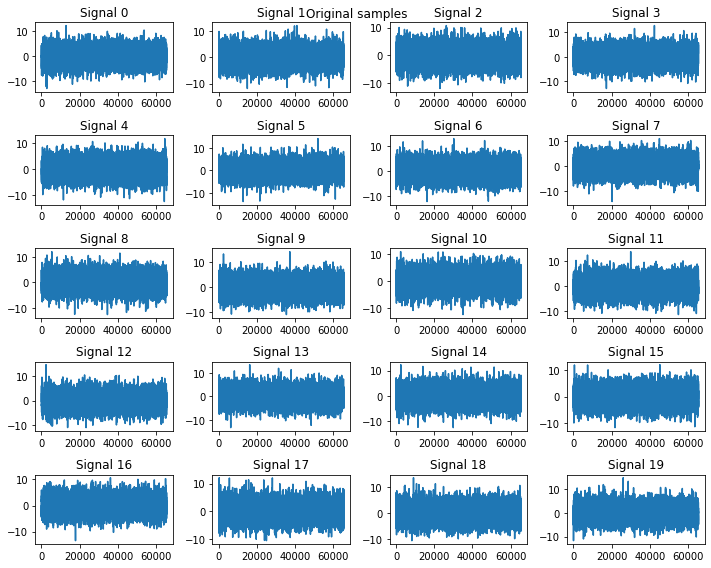

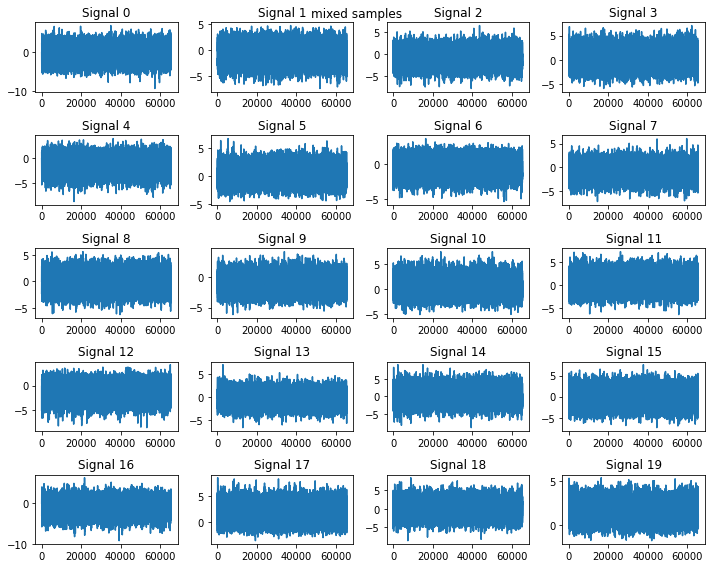

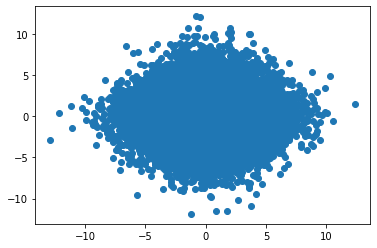

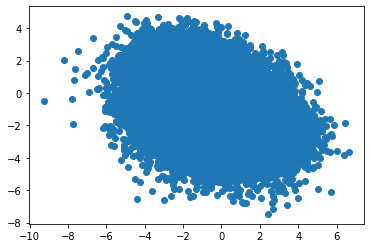

In [ ]:
fig, ax = plt.subplots(5, 4, figsize = (10, 8))
ax = ax.flatten()
fig.suptitle("Original samples")
for i in range(n_size):
  ax[i].set_title("Signal {}".format(i))
  ax[i].plot(TCL_data.samples[:, i])
plt.tight_layout()
plt.show()

print("\n")
fig, ax = plt.subplots(5, 4, figsize = (10, 8))
ax = ax.flatten()
fig.suptitle("mixed samples")
for i in range(n_size):
  ax[i].set_title("Signal {}".format(i))
  ax[i].plot(TCL_data.mixed_samples[:, i])
plt.tight_layout()
plt.show()

if n_size == 2:
    plt.figure()
    plt.scatter(TCL_data.samples[:, 0], TCL_data.samples[:, 1], c = TCL_data.colors)
    plt.show()

    plt.figure()
    plt.scatter(TCL_data.mixed_samples[:, 0], TCL_data.mixed_samples[:, 1], c = TCL_data.colors)
    plt.show()

else:
    print("\n")
    plt.figure()
    plt.scatter(TCL_data.samples[:, 0], TCL_data.samples[:, 1])
    plt.show()

    print("\n")
    plt.figure()
    plt.scatter(TCL_data.mixed_samples[:, 0], TCL_data.mixed_samples[:, 1])
    plt.show()

In [ ]:
f_model = feature_MLP(n_size, n_layers + 1, maxout_flag = True)
r_model = RegressionModel(n_size)

device = torch.device("cuda:0" if torch.cuda.is_available else "cpu") #torch.device("cpu")#
print(f_model, r_model)

f_model.to(device)
r_model.to(device)

ls = list(f_model.parameters()) + list(r_model.parameters())

optim = torch.optim.Adam(ls, lr= 1e-2)#, momentum = 0.25, weight_decay = 0.0001)
loss = torch.nn.BCELoss()
batch_sample = True

cost = []

epochs = 1000
pbar = pbar = tqdm(total = epochs, desc = "cost at epoch {}: {}".format(0, np.inf)) 

for i in range(epochs):
    cost_val = 0
    N = 0
    flag = True
    
    if batch_sample:
        while flag == True:
            Y1, Y2, l1, flag = TCL_data.batch_sample(256, include_end = True)

            if flag:
                H1 = f_model(Y1.to(device))
                H2 = f_model(Y2.to(device))

                out = r_model(H1, H2)
                loss_iter = loss(out, l1.to(device))
                loss_iter.backward()
                optim.step()
                
                cost_val += loss_iter.item()
                N += 1
                optim.zero_grad()
            
            else:
                pass

    else:

        N = 1
        Y1, Y2, l1 = TCL_data.random_sample(256)
        H1 = f_model(Y1.to(device))
        H2 = f_model(Y2.to(device))

        out = r_model(H1, H2)
        loss_iter = loss(out, l1.to(device))
        loss_iter.backward()
        optim.step()
        
        cost_val = loss_iter.item()
        optim.zero_grad()
      
    cost.append(cost_val / N)
    pbar.set_description("cost at epoch {}: {:.4f}".format(i, cost[-1]))
    pbar.update(1)

    if int(cost[-1]) == 50: #stop the thing from just failing and having to restart the notebook.
      pbar.close()
      break
    
pbar.close()


cost at epoch 0: inf:   0%|          | 0/1000 [00:00<?, ?it/s]

feature_MLP(
  (activation): LeakyReLU(negative_slope=0.1)
  (model): Sequential(
    (0): Maxout_linear_layer(
      (maxout_layer): Linear(in_features=20, out_features=40, bias=True)
    )
    (1): Maxout_linear_layer(
      (maxout_layer): Linear(in_features=20, out_features=40, bias=True)
    )
    (2): Linear(in_features=20, out_features=20, bias=True)
  )
) RegressionModel(
  (activation): Sigmoid()
)


cost at epoch 999: 0.1120: 100%|██████████| 1000/1000 [40:58<00:00,  2.46s/it]


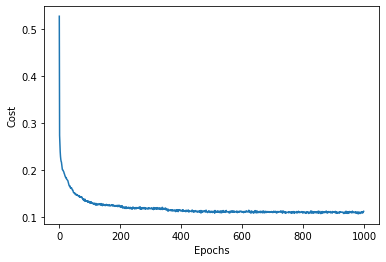

In [ ]:
plt.figure()
plt.plot(cost)
plt.ylabel("Cost")
plt.xlabel("Epochs")
plt.show()

[0.631 1.    0.963 ... 0.    0.66  0.028]
3903 3940
Accuracy: 0.9573974609375


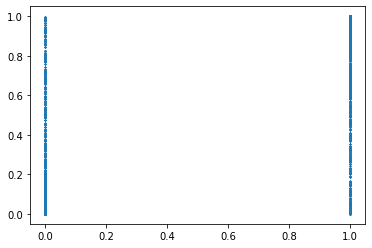

In [ ]:
no_samples_test = 8192
Y1, Y2, l1 = TCL_data.random_sample(no_samples_test)

with torch.no_grad():
    H1 = f_model(Y1.to(device))
    H2 = f_model(Y2.to(device))

    out = r_model(H1, H2)
    out = out.cpu().numpy()
    print(np.round(out, 3))
    print(np.sum(out[0:no_samples_test//2] > 0.5), np.sum(out[no_samples_test//2:] < 0.5))
    
    acc = (np.sum(out[0:no_samples_test//2] > 0.5) + np.sum(out[no_samples_test//2:] < 0.5)) / no_samples_test
    
    print("Accuracy: {}".format(acc))
    
    plt.figure()
    plt.scatter(l1, out, s = 2, marker = "x")
    plt.show()


In [ ]:
with torch.no_grad():

    N = len(TCL_data.Yreal)
    batch_size = 512
    Hpred1 = np.zeros((N, n_size))
    Hpred2 = np.zeros((N, n_size))
    Hpred3 = np.zeros((N + 1, n_size))
    Label = np.zeros(N)

    for i in range(0, N, batch_size):
        start = i
        end = min(start + batch_size, N)

        Y1 = torch.zeros(batch_size, n_size)
        Y2 = torch.zeros(batch_size, n_size)
        Y3 = torch.zeros(batch_size, n_size)

        for cnt, j in enumerate(range(start, end, 1)):
            Y1[cnt, :] = TCL_data.Yreal[j][0]
            Y2[cnt, :] = TCL_data.Yreal[j][1]
        
        Y3[0:end - start, :] = TCL_data.mixed_samples[start:end, :]

        h1 = f_model(Y1.to(device))
        h2 = f_model(Y2.to(device))
        h3 = f_model(Y3.to(device))
        
        l_pred = r_model(h1, h2)

        Hpred1[start:end, :] = h1[:end - start, :].detach().cpu().numpy()
        Hpred2[start:end, :] = h2[:end - start, :].detach().cpu().numpy()
        Hpred3[start:end, :] = h3[:end - start, :].detach().cpu().numpy()
        Label[start:end] = l_pred[:end - start].detach().cpu().numpy()

Hpred3[-1, :] = f_model(TCL_data.mixed_samples[-1, :].to(device)).detach().cpu().numpy()

<Figure size 432x288 with 0 Axes>

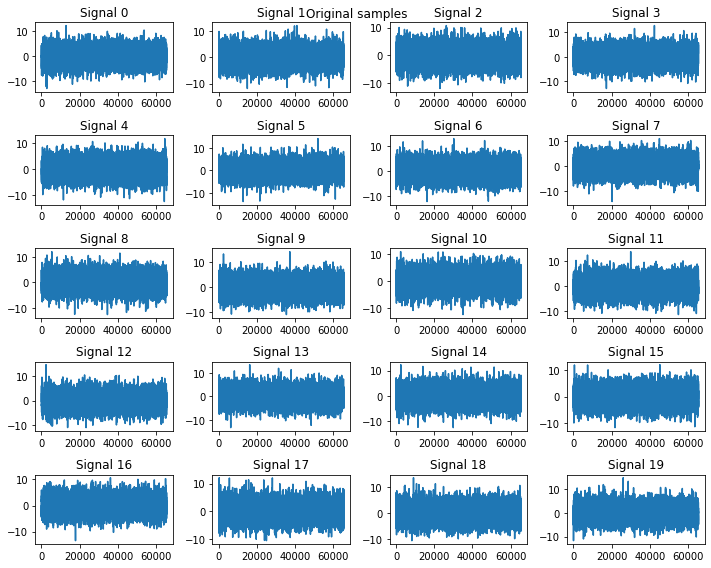

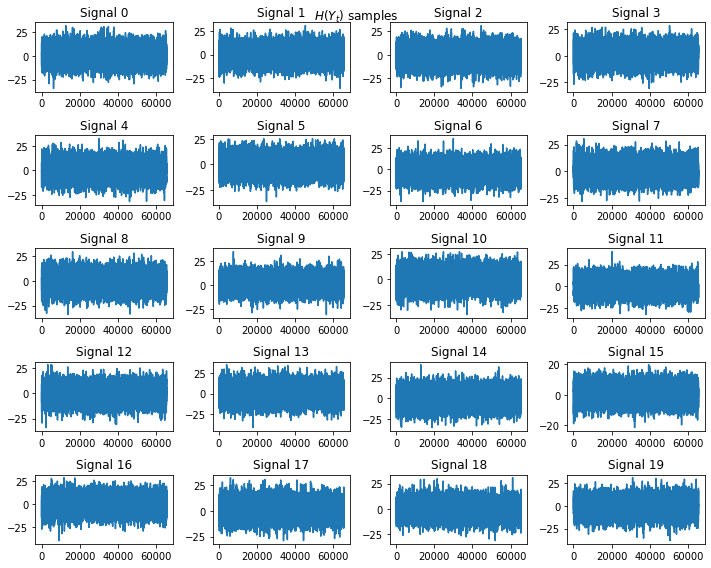

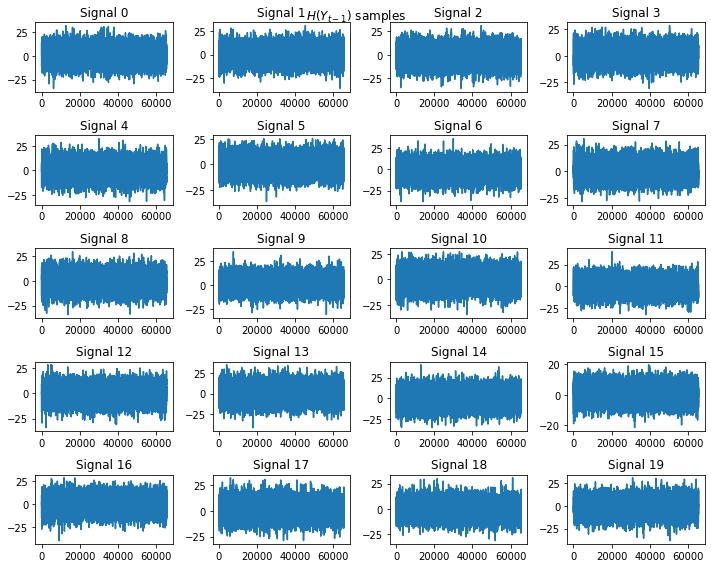

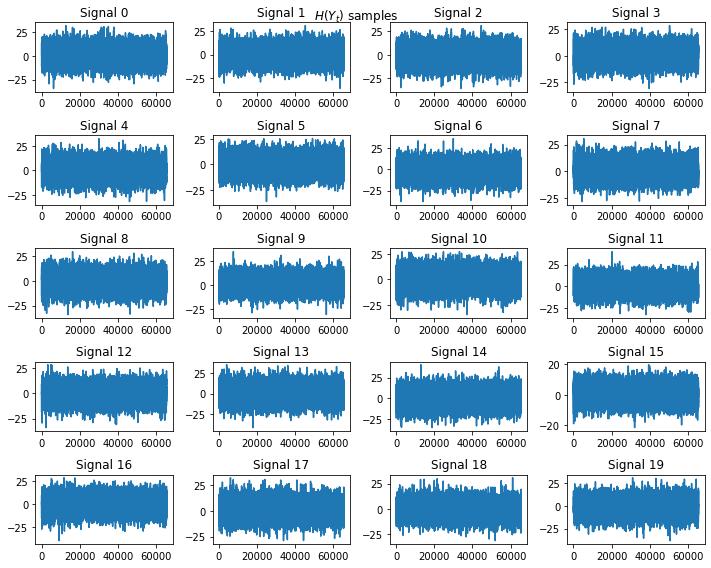

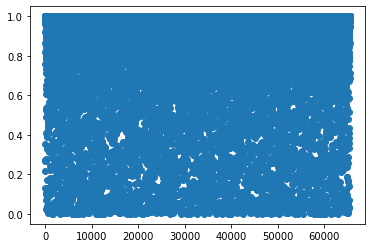

0.9539787899595636


In [ ]:
try:
    plt.figure()
    plt.scatter(Hpred3[:, 0], Hpred3[:, 1], color = TCL_data.colors)
    plt.show()
    
except:
    pass
    
fig, ax = plt.subplots(5, 4, figsize = (10, 8))
fig.suptitle("Original samples")
ax = ax.flatten()
for i in range(n_size):
  ax[i].set_title("Signal {}".format(i))
  ax[i].plot(TCL_data.samples[:, i])
plt.tight_layout()
plt.show()

print("\n")
fig, ax = plt.subplots(5, 4, figsize = (10, 8))
fig.suptitle(r"$H(Y_{t})$ samples")
ax = ax.flatten()
for i in range(n_size):
  ax[i].set_title("Signal {}".format(i))
  ax[i].plot(Hpred1[:, i])
plt.tight_layout()
plt.show()

print("\n")
fig, ax = plt.subplots(5, 4, figsize = (10, 8))
fig.suptitle(r"$H(Y_{t - 1})$ samples")
ax = ax.flatten()
for i in range(n_size):
  ax[i].set_title("Signal {}".format(i))
  ax[i].plot(Hpred2[:, i])
plt.tight_layout()
plt.show()

print("\n")
fig, ax = plt.subplots(5, 4, figsize = (10, 8))
fig.suptitle(r"$H(Y_{t})$ samples")
ax = ax.flatten()
for i in range(n_size):
  ax[i].set_title("Signal {}".format(i))
  ax[i].plot(Hpred3[:, i])
plt.tight_layout()
plt.show()

plt.figure()
plt.scatter(range(len(Label)), Label)
plt.show()

print(np.sum(Label > 0.5) / N)



In [ ]:
print(len(TCL_data.rand_indices), len(Hpred3))

N_labels = len(TCL_data.rand_indices)
train_labels = Label[TCL_data.rand_indices[0:int(0.8 * N)]]
test_labels = Label[TCL_data.rand_indices[int(0.8 * N):]]

train_acc = np.sum(train_labels > 0.5) / (0.8 * N_labels)
test_acc = np.sum(test_labels > 0.5) / (0.2 * N_labels)

print(train_acc, test_acc)

65535 65536
0.9549095902952621 0.9502555886167696


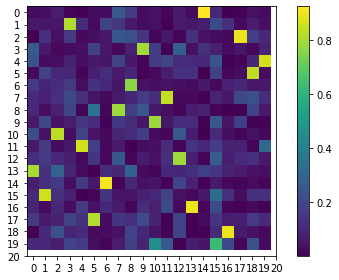

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] [14  3 17  9 19 18  8 11  7 10  2  4 12  0  6  1 13  5 16 15]
Coor: [0.92659375 0.81973769 0.8998119  0.79777634 0.86516603 0.83555213
 0.76570175 0.84120678 0.79217046 0.78754101 0.83251018 0.86481071
 0.78947672 0.80535152 0.91094073 0.86081992 0.89882172 0.82039336
 0.89897992 0.63274957]
MCC: 0.8323056097926136




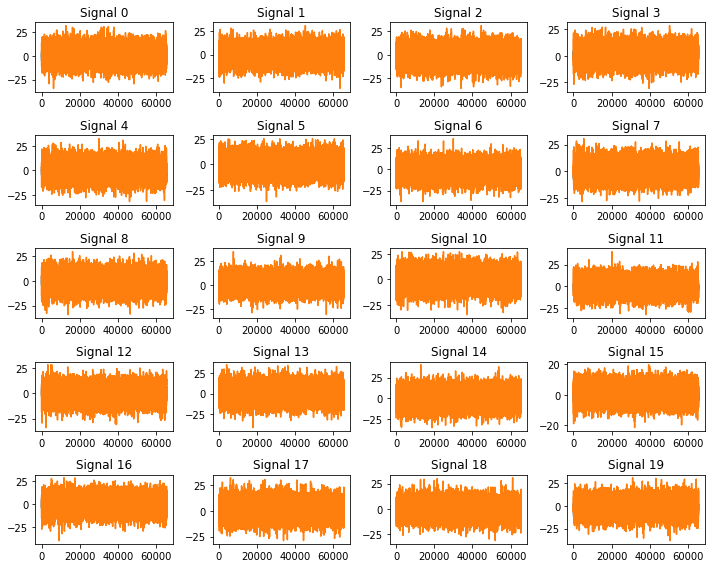

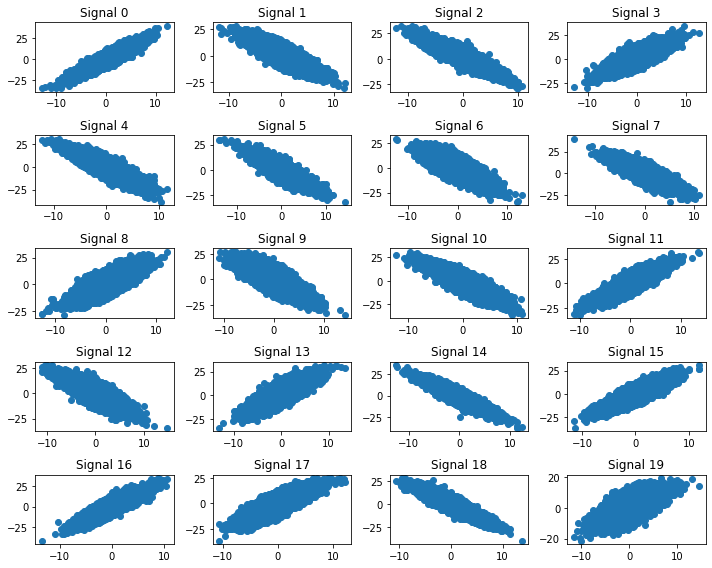

In [ ]:
corr = np.zeros((n_size, n_size))

for i in range(n_size):
    
    for j in range(n_size):
        s1 = TCL_data.samples[:, i].numpy()
        s2 = Hpred3[:, j]

        corr[i, j] = np.abs(np.corrcoef(s1, s2))[0,1]#correlation_coeff(TCL_data.samples[1:, i].numpy(), Hpred1[:, j])

plt.figure()
plt.imshow(corr)
plt.colorbar()
plt.xticks(range(0, n_size + 1, 1))
plt.yticks(range(0, n_size + 1, 1))
plt.tight_layout()
plt.show()

#LSAP to get optimal sources
row_ind, col_ind = linear_sum_assignment(corr, maximize = True) #col_ind is what you want
print(row_ind, col_ind)

MCC = np.mean(corr[row_ind, col_ind])
print("Coor: {}".format(corr[row_ind, col_ind]))
print("MCC: {}".format(MCC))

print("\n")
fig, ax = plt.subplots(5, 4, figsize = (10, 8))
ax = ax.flatten()
for i, j in zip(range(n_size), col_ind):
  ax[i].set_title("Signal {}".format(i))
  ax[i].plot(TCL_data.samples[:, i].numpy())
  ax[i].plot(Hpred3[:, i])

plt.tight_layout()
plt.show()

print("\n")
fig, ax = plt.subplots(5, 4, figsize = (10, 8))
ax = ax.flatten()
for i in range(n_size):
  ax[i].set_title("Signal {}".format(i))
  ax[i].scatter(TCL_data.samples[:, i].numpy(), Hpred3[:, col_ind[i]])

plt.tight_layout()
plt.show()
